In [1]:
import os
import sys
import struct

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import torch

# from sklearn.cluster import KMeans, spectral_clustering, DBSCAN
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy


/home/jd.guerrero/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("/home/jd.guerrero/Documents/g.esposito/AlternativeModels-SC2/")
path = os.getcwd()

log_folders = [file_path for file_path in os.listdir("/home/jd.guerrero/Documents/g.esposito/AlternativeModels-SC2/") if file_path.startswith("FSIM_W_local_obj_smaller_cut_L")]
# print(log_folders)

ref_general_report = pd.DataFrame([])
ref_new_report = pd.DataFrame([])
for layer_conf in log_folders:
    if layer_conf != ".DS_Store":
        folder_path = os.path.join(path,  layer_conf)
        for cnf in [files for files in os.listdir(folder_path) if files != ".DS_Store" and not files.endswith('.log')]:
            file_path = os.path.join(folder_path, cnf)

            report_path = os.path.join(file_path, "fsim_full_report.csv")
            report = pd.read_csv(report_path)
            report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            report['bit_faulty_position'] = np.log2(report['bitmask'])
            report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)

            indices = report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0").index
            for idx in indices:
                report.loc[idx, 'boxes_Crit'] = report.loc[idx, 'average_golden_boxes']*100

            tot_boxes_per_fault = report['boxes_Crit'] + report['boxes_SDC'] + report['boxes_Masked']
            # for val in tot_boxes_per_fault:
            #     if val == 0:
            #         print('queste sono tutte critiche')
            report['Crit_perc'] = (report['boxes_Crit'] / tot_boxes_per_fault)*100
            report['SDC_perc'] = (report['boxes_SDC'] / tot_boxes_per_fault)*100
            report['masked_perc'] = (report['boxes_Masked'] / tot_boxes_per_fault)*100
            ref_general_report = pd.concat([ref_general_report, report], axis=0, ignore_index=True)

            new_path = os.path.join(file_path, "Faulty_boxes_report.csv")
            additional_report = pd.read_csv(new_path)
            additional_report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            additional_report['bit_faulty_position'] = np.log2(additional_report['bitmask'])
            additional_report.drop(columns=['Unnamed: 0'], inplace=True)
            ref_new_report = pd.concat([ref_new_report, additional_report], axis=0, ignore_index=True)
    

    # ref_general_report.loc[indices]['Crit_perc'].fillna(1, inplace=True)
    # ref_general_report.loc[indices,'SDC_perc'].fillna(0, inplace=True)
    # ref_general_report.loc[indices,'masked_perc'].fillna(0, inplace=True)

# indices = ref_general_report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0")
# print(indices)
ref_new_report['iou_score'] = ref_new_report['iou score']
ref_general_report.shape
ref_general_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask', 'gold_iou@1',
       'boxes_Crit', 'boxes_SDC', 'boxes_Masked', 'fault_iou@1', 'Class',
       'area_ratio', 'average_golden_boxes', 'average_faulty_boxes',
       'average_target_boxes', 'Layer', 'Ffree_Weight', 'Faulty_weight',
       'Abs_error', 'conf_detail', 'bit_faulty_position', 'Crit_perc',
       'SDC_perc', 'masked_perc'],
      dtype='object')

In [3]:
ref_new_report.columns

Index(['FaultID', 'imID', 'layer', 'kernel', 'channel', 'row', 'col',
       'bitmask', 'G_lab', 'g_bb', 'f_bb', 'F_count', 'F_lab', 'G_count',
       'G_score', 'T_count', 'area_ratio', 'confidence_covered',
       'f_candidate_conf', 'iou score', 'conf_detail', 'bit_faulty_position',
       'iou_score'],
      dtype='object')

In [4]:
os.chdir("/home/jd.guerrero/Documents/g.esposito/AlternativeModels-SC2/")
path = os.getcwd()

log_folders = [file_path for file_path in os.listdir("/home/jd.guerrero/Documents/g.esposito/AlternativeModels-SC2/") if file_path.startswith("FSIM_W_local_obj_smaller_cut_custom")]
# print(log_folders)

custom_general_report = pd.DataFrame([])
custom_new_report = pd.DataFrame([])
for layer_conf in log_folders:
    if layer_conf != ".DS_Store":
        folder_path = os.path.join(path,  layer_conf)
        for cnf in [files for files in os.listdir(folder_path) if files != ".DS_Store" and not files.endswith('.log')]:
            file_path = os.path.join(folder_path, cnf)

            report_path = os.path.join(file_path, "fsim_full_report.csv")
            report = pd.read_csv(report_path)
            report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            report['bit_faulty_position'] = np.log2(report['bitmask'])
            report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)

            indices = report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0").index
            for idx in indices:
                report.loc[idx, 'boxes_Crit'] = report.loc[idx, 'average_golden_boxes']*100

            tot_boxes_per_fault = report['boxes_Crit'] + report['boxes_SDC'] + report['boxes_Masked']
            # for val in tot_boxes_per_fault:
            #     if val == 0:
            #         print('queste sono tutte critiche')
            report['Crit_perc'] = (report['boxes_Crit'] / tot_boxes_per_fault)*100
            report['SDC_perc'] = (report['boxes_SDC'] / tot_boxes_per_fault)*100
            report['masked_perc'] = (report['boxes_Masked'] / tot_boxes_per_fault)*100
            custom_general_report = pd.concat([custom_general_report, report], axis=0, ignore_index=True)

            new_path = os.path.join(file_path, "Faulty_boxes_report.csv")
            additional_report = pd.read_csv(new_path)
            additional_report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            additional_report['bit_faulty_position'] = np.log2(additional_report['bitmask'])
            additional_report.drop(columns=['Unnamed: 0'], inplace=True)
            custom_new_report = pd.concat([custom_new_report, additional_report], axis=0, ignore_index=True)
    

    # custom_general_report.loc[indices]['Crit_perc'].fillna(1, inplace=True)
    # custom_general_report.loc[indices,'SDC_perc'].fillna(0, inplace=True)
    # custom_general_report.loc[indices,'masked_perc'].fillna(0, inplace=True)

# indices = custom_general_report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0")
# print(indices)
custom_new_report['iou_score'] = custom_new_report['iou score']
custom_general_report.shape
custom_general_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask', 'gold_iou@1',
       'boxes_Crit', 'boxes_SDC', 'boxes_Masked', 'fault_iou@1', 'Class',
       'area_ratio', 'average_golden_boxes', 'average_faulty_boxes',
       'average_target_boxes', 'Layer', 'Ffree_Weight', 'Faulty_weight',
       'Abs_error', 'conf_detail', 'bit_faulty_position', 'Crit_perc',
       'SDC_perc', 'masked_perc'],
      dtype='object')

In [5]:
os.chdir("/home/jd.guerrero/Documents/g.esposito/AlternativeModels-SC2/")
path = os.getcwd()

log_folders = [file_path for file_path in os.listdir("/home/jd.guerrero/Documents/g.esposito/AlternativeModels-SC2/") if file_path.startswith("FSIM_W_local_obj_smaller_cut_quant")]
# print(log_folders)

quant_general_report = pd.DataFrame([])
quant_new_report = pd.DataFrame([])
for layer_conf in log_folders:
    if layer_conf != ".DS_Store":
        folder_path = os.path.join(path,  layer_conf)
        for cnf in [files for files in os.listdir(folder_path) if files != ".DS_Store" and not files.endswith('.log')]:
            file_path = os.path.join(folder_path, cnf)

            report_path = os.path.join(file_path, "fsim_full_report.csv")
            report = pd.read_csv(report_path)
            report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            report['bit_faulty_position'] = np.log2(report['bitmask'])
            report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)

            indices = report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0").index
            for idx in indices:
                report.loc[idx, 'boxes_Crit'] = report.loc[idx, 'average_golden_boxes']*100

            tot_boxes_per_fault = report['boxes_Crit'] + report['boxes_SDC'] + report['boxes_Masked']
            # for val in tot_boxes_per_fault:
            #     if val == 0:
            #         print('queste sono tutte critiche')
            report['Crit_perc'] = (report['boxes_Crit'] / tot_boxes_per_fault)*100
            report['SDC_perc'] = (report['boxes_SDC'] / tot_boxes_per_fault)*100
            report['masked_perc'] = (report['boxes_Masked'] / tot_boxes_per_fault)*100
            quant_general_report = pd.concat([quant_general_report, report], axis=0, ignore_index=True)

            new_path = os.path.join(file_path, "Faulty_boxes_report.csv")
            additional_report = pd.read_csv(new_path)
            additional_report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            additional_report['bit_faulty_position'] = np.log2(additional_report['bitmask'])
            additional_report.drop(columns=['Unnamed: 0'], inplace=True)
            quant_new_report = pd.concat([quant_new_report, additional_report], axis=0, ignore_index=True)
    

    # quant_general_report.loc[indices]['Crit_perc'].fillna(1, inplace=True)
    # quant_general_report.loc[indices,'SDC_perc'].fillna(0, inplace=True)
    # quant_general_report.loc[indices,'masked_perc'].fillna(0, inplace=True)

# indices = quant_general_report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0")
# print(indices)
quant_new_report['iou_score'] = quant_new_report['iou score']
quant_general_report.shape
quant_general_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask', 'gold_iou@1',
       'boxes_Crit', 'boxes_SDC', 'boxes_Masked', 'fault_iou@1', 'Class',
       'area_ratio', 'average_golden_boxes', 'average_faulty_boxes',
       'average_target_boxes', 'Layer', 'Ffree_Weight', 'Faulty_weight',
       'Abs_error', 'conf_detail', 'bit_faulty_position', 'Crit_perc',
       'SDC_perc', 'masked_perc'],
      dtype='object')

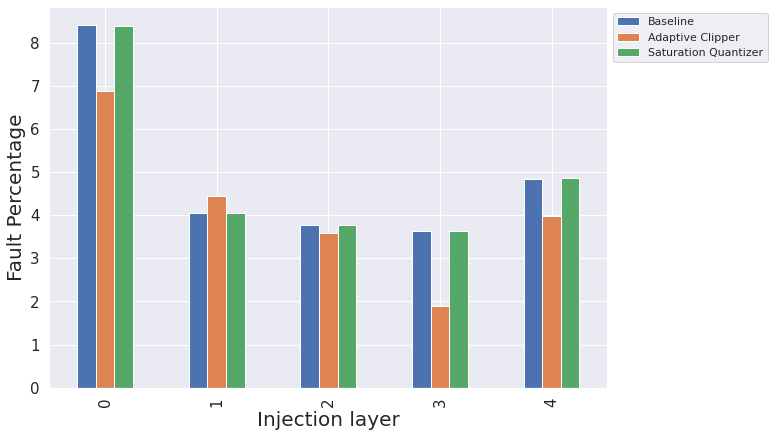

In [5]:
mean_percentages_crit = pd.DataFrame([])
mean_percentages_crit['Baseline'] = ref_general_report.groupby(['layer'])['Crit_perc'].mean()
mean_percentages_crit['Adaptive Clipper'] = custom_general_report.groupby(['layer'])['Crit_perc'].mean()
mean_percentages_crit['Saturation Quantizer'] = quant_general_report.groupby(['layer'])['Crit_perc'].mean()
sns.set()
fig, ax = plt.subplots(1,1, figsize=(10,7))
mean_percentages_crit.plot(kind='bar', ax = ax)
ax.legend(labels=['Baseline', 'Adaptive Clipper', 'Saturation Quantizer'])
# ax.legend(labels=['Baseline', 'Adaptive Clipper'])
ax.set_xlabel('Injection layer', fontsize=20)
ax.set_ylabel('Fault Percentage', fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
sns.move_legend(ax,'upper left',  bbox_to_anchor=(1, 1))

In [116]:
mean_percentages_SDC['Adaptive Clipper']

layer
0    93.069338
1    75.121463
2    65.626169
3    45.877161
4    46.961688
Name: Adaptive Clipper, dtype: float64

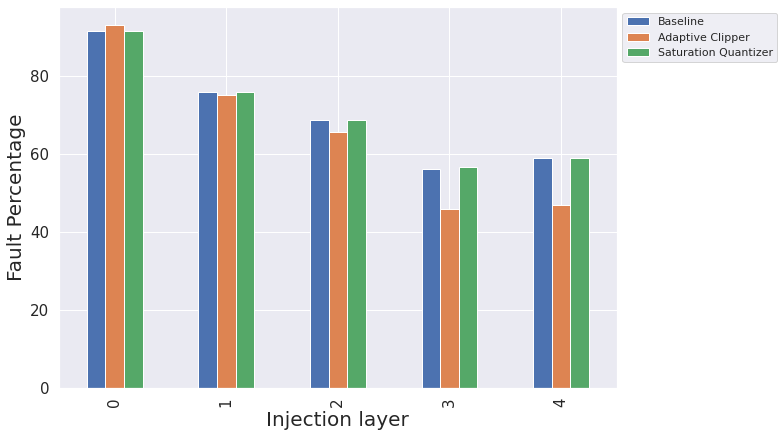

In [7]:
mean_percentages_SDC = pd.DataFrame([])
mean_percentages_SDC['Baseline'] = ref_general_report.groupby(['layer'])['SDC_perc'].mean()
mean_percentages_SDC['Adaptive Clipper'] = custom_general_report.groupby(['layer'])['SDC_perc'].mean()
mean_percentages_SDC['Saturation Quantizer'] = quant_general_report.groupby(['layer'])['SDC_perc'].mean()

sns.set()
fig, ax = plt.subplots(1,1, figsize=(10,7))
mean_percentages_SDC.plot(kind='bar', ax = ax)
ax.legend(labels=['Baseline', 'Adaptive Clipper', 'Saturation Quantizer'])
ax.set_xlabel('Injection layer', fontsize=20)
ax.set_ylabel('Fault Percentage', fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
sns.move_legend(ax,'upper left',  bbox_to_anchor=(1, 1))

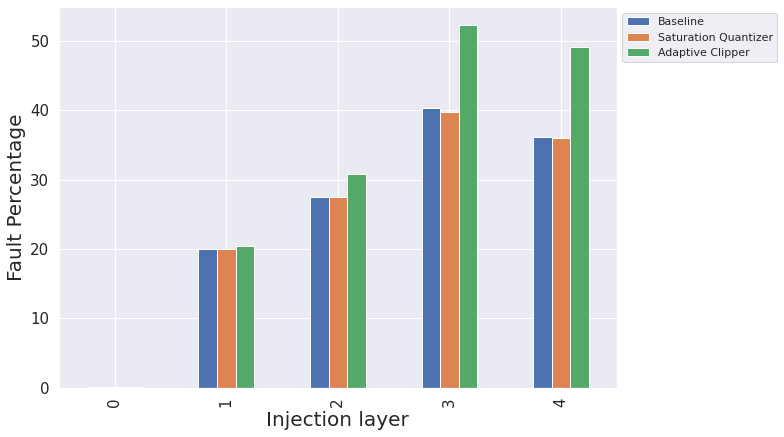

In [6]:
mean_percentages_masked = pd.DataFrame([])
mean_percentages_masked['Baseline'] = ref_general_report.groupby(['layer'])['masked_perc'].mean()
mean_percentages_masked['Saturation Quantizer'] = quant_general_report.groupby(['layer'])['masked_perc'].mean()
mean_percentages_masked['Adaptive Clipper'] = custom_general_report.groupby(['layer'])['masked_perc'].mean()

sns.set()
fig, ax = plt.subplots(1,1, figsize=(10,7))
mean_percentages_masked.plot(kind='bar', ax = ax)
ax.legend(labels=['Baseline', 'Saturation Quantizer', 'Adaptive Clipper'])
# ax.legend(labels=['Baseline', 'Adaptive Clipper'])
ax.set_xlabel('Injection layer', fontsize=20)
ax.set_ylabel('Fault Percentage', fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
sns.move_legend(ax,'upper left',  bbox_to_anchor=(1, 1))

In [7]:
mean_percentages_masked['Adaptive Clipper'].mean() - mean_percentages_masked['Baseline'].mean()

5.7254666911789975

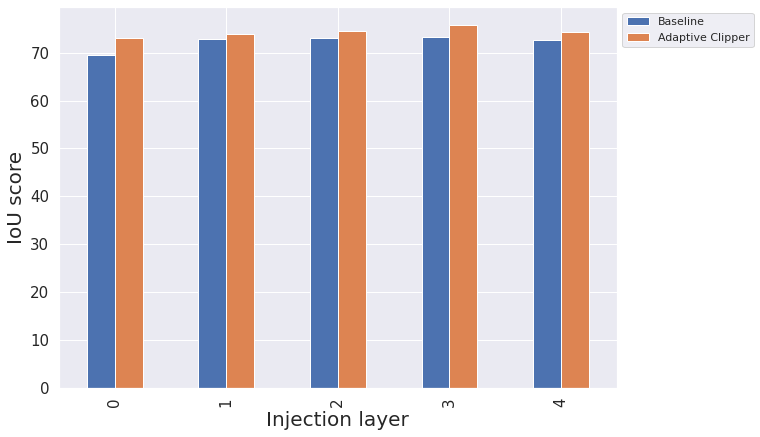

In [119]:
mean_percentages_MRAD = pd.DataFrame([])
mean_percentages_MRAD['Baseline'] = ref_general_report.groupby(['layer'])['fault_iou@1'].mean()
mean_percentages_MRAD['Adaptive Clipper'] = custom_general_report.groupby(['layer'])['fault_iou@1'].mean()
# mean_percentages_MRAD['Saturation Quantizer'] = quant_general_report.groupby(['layer'])['fault_iou@1'].mean()

sns.set()
fig, ax = plt.subplots(1,1, figsize=(10,7))
mean_percentages_MRAD.plot(kind='bar', ax = ax)
# ax.legend(labels=['Baseline', 'Adaptive Clipper', 'Saturation Quantizer'])
ax.legend(labels=['Baseline', 'Adaptive Clipper'])
ax.set_xlabel('Injection layer', fontsize=20)
ax.set_ylabel('IoU score', fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
sns.move_legend(ax,'upper left',  bbox_to_anchor=(1, 1))

In [11]:
# fig, ax = plt.subplots(1,1, figsize=(10,5))
ref_new_report['majority'] = None
indices_f_maj = ref_new_report.query("F_count > G_count").index
ref_new_report.loc[indices_f_maj,'majority'] = 'F_maj'

indices_g_maj = ref_new_report.query("F_count < G_count").index
ref_new_report.loc[indices_g_maj,'majority'] = 'G_maj'
# for idx in indices:
indices_eq = ref_new_report.query("F_count == G_count").index
ref_new_report.loc[indices_eq,'majority'] = 'eq'

# nan_indices = ref_new_report.isna().index
nan_indices = ref_new_report.query("F_lab.isnull()").index
ref_new_report.loc[nan_indices,'majority'] = 'not_predicted'

ref_new_report['Injection layer'] = ref_new_report['layer']
category_totals = ref_new_report['Injection layer'].value_counts()
def calculate_percentage(row):
    category_total = category_totals[row['Injection layer']]
    return (row['counting'] / category_total) * 100

findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.


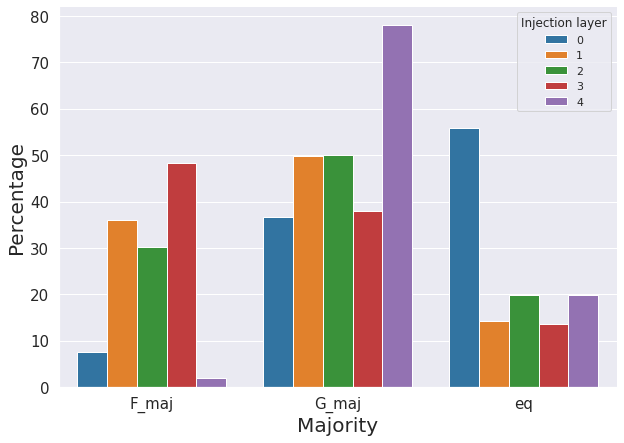

In [12]:
sns.set()
fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.despine(fig)
counts = ref_new_report.groupby(['Injection layer', 'majority']).size().reset_index(name='counting')
counts['perc'] = counts.apply(calculate_percentage, axis=1)

sns.barplot(x='majority', y='perc', hue='Injection layer', data=counts, ax = ax, palette='tab10')
ax.set_xlabel('Majority', fontsize=20, fontname='Georgia')
ax.set_ylabel('Percentage', fontsize=20)
ax.tick_params('x', labelsize=15)
ax.tick_params('y', labelsize=15)

In [22]:
# fig, ax = plt.subplots(1,1, figsize=(10,5))
custom_new_report['majority'] = None
indices_f_maj = custom_new_report.query("F_count > G_count").index
custom_new_report.loc[indices_f_maj,'majority'] = 'F_maj'

indices_g_maj = custom_new_report.query("F_count < G_count").index
custom_new_report.loc[indices_g_maj,'majority'] = 'G_maj'
# for idx in indices:
indices_eq = custom_new_report.query("F_count == G_count").index
custom_new_report.loc[indices_eq,'majority'] = 'eq'

# nan_indices = custom_new_report.isna().index
nan_indices = custom_new_report.query("F_lab.isnull()").index
custom_new_report.loc[nan_indices,'majority'] = 'not_predicted'

custom_new_report['Injection layer'] = custom_new_report['layer']
category_totals = custom_new_report['Injection layer'].value_counts()
def calculate_percentage(row):
    category_total = category_totals[row['Injection layer']]
    return (row['counting'] / category_total) * 100

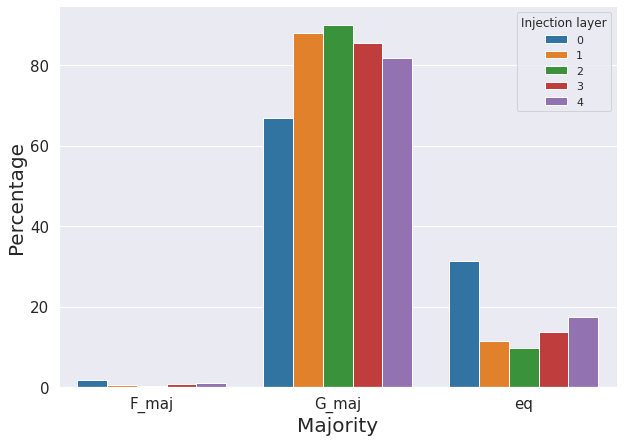

In [23]:
sns.set()
fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.despine(fig)
counts = custom_new_report.groupby(['Injection layer', 'majority']).size().reset_index(name='counting')
counts['perc'] = counts.apply(calculate_percentage, axis=1)

sns.barplot(x='majority', y='perc', hue='Injection layer', data=counts, ax = ax, palette='tab10')
ax.set_xlabel('Majority', fontsize=20, fontname='Georgia')
ax.set_ylabel('Percentage', fontsize=20)
ax.tick_params('x', labelsize=15)
ax.tick_params('y', labelsize=15)

In [13]:
# fig, ax = plt.subplots(1,1, figsize=(10,5))
quant_new_report['majority'] = None
indices_f_maj = quant_new_report.query("F_count > G_count").index
quant_new_report.loc[indices_f_maj,'majority'] = 'F_maj'

indices_g_maj = quant_new_report.query("F_count < G_count").index
quant_new_report.loc[indices_g_maj,'majority'] = 'G_maj'
# for idx in indices:
indices_eq = quant_new_report.query("F_count == G_count").index
quant_new_report.loc[indices_eq,'majority'] = 'eq'

# nan_indices = quant_new_report.isna().index
nan_indices = quant_new_report.query("F_lab.isnull()").index
quant_new_report.loc[nan_indices,'majority'] = 'not_predicted'

quant_new_report['Injection layer'] = quant_new_report['layer']
category_totals = quant_new_report['Injection layer'].value_counts()
def calculate_percentage(row):
    category_total = category_totals[row['Injection layer']]
    return (row['counting'] / category_total) * 100

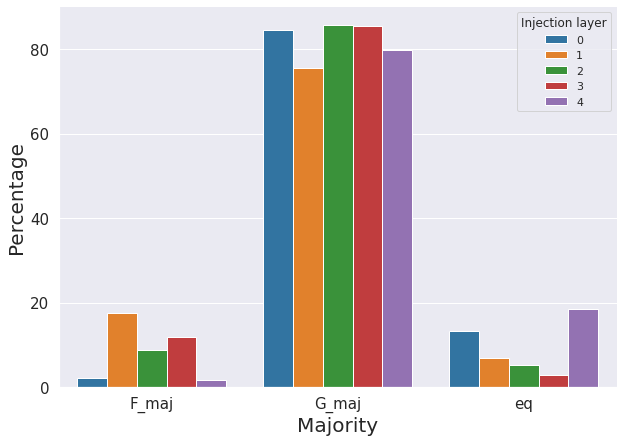

In [14]:
sns.set()
fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.despine(fig)
counts = quant_new_report.groupby(['Injection layer', 'majority']).size().reset_index(name='counting')
counts['perc'] = counts.apply(calculate_percentage, axis=1)

sns.barplot(x='majority', y='perc', hue='Injection layer', data=counts, ax = ax, palette='tab10')
ax.set_xlabel('Majority', fontsize=20, fontname='Georgia')
ax.set_ylabel('Percentage', fontsize=20)
ax.tick_params('x', labelsize=15)
ax.tick_params('y', labelsize=15)

## Confidence Covered

<AxesSubplot:xlabel='bit_faulty_position', ylabel='percentage of boxes that are above the confidence threshold'>

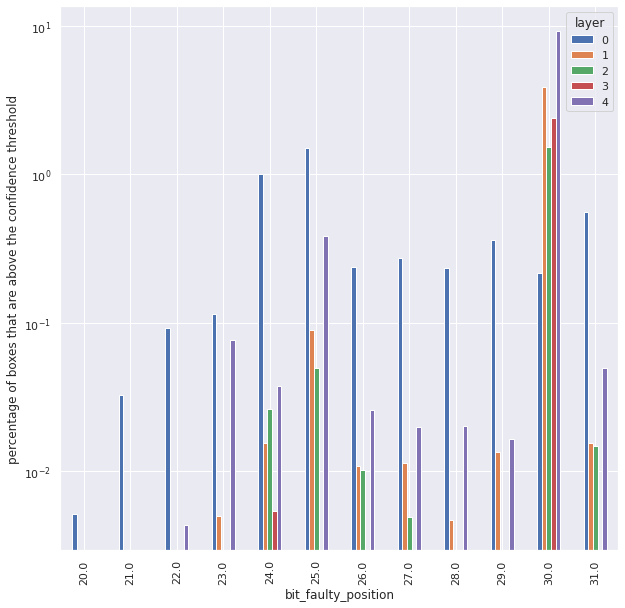

In [30]:
ref_new_report['confidence_ratio'] = ref_new_report['f_candidate_conf'] / ref_new_report['G_score']
# score_report = ref_new_report.query("confidence_covered==0.0")
crit_perc_per_layer_per_bit = ref_general_report.groupby(by=["bit_faulty_position", "layer"]).mean()['Crit_perc']/100
ref_new_report['confidence_coverage'] = ref_new_report.groupby(by=['layer', 'bit_faulty_position'])['confidence_covered'].transform(lambda x: x.sum())
ref_new_report['confidence_coverage']
crit_perc_per_layer_per_bit = ref_general_report.groupby(by=["bit_faulty_position", "layer"]).sum()['boxes_Crit'] + ref_general_report.groupby(by=["bit_faulty_position", "layer"]).sum()['boxes_SDC'] + ref_general_report.groupby(by=["bit_faulty_position", "layer"]).sum()['boxes_Masked']
grouped_confidence = ref_new_report.groupby(by=['layer', 'bit_faulty_position'])['confidence_covered'].sum()/crit_perc_per_layer_per_bit*100
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_ylabel('percentage of boxes that are above the confidence threshold')
ax.set_yscale('log')
grouped_confidence.unstack().transpose().plot(kind="bar", ax = ax, grid=True)

<AxesSubplot:xlabel='bit_faulty_position', ylabel='percentage of boxes that are above the confidence threshold'>

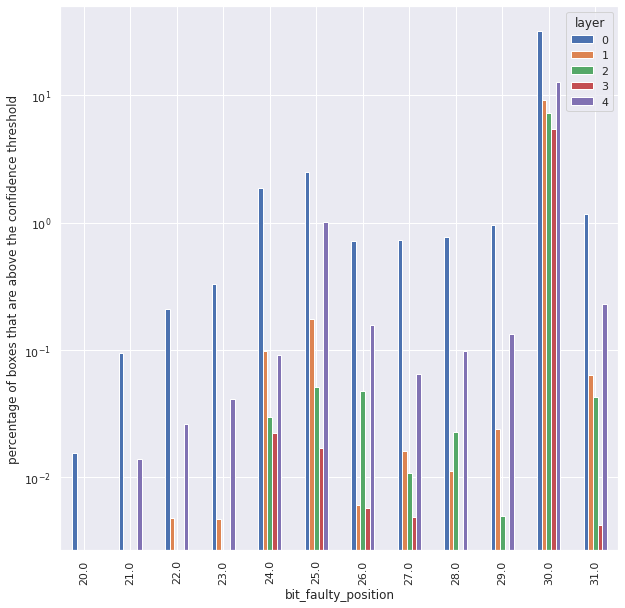

In [31]:
custom_new_report['confidence_ratio'] = custom_new_report['f_candidate_conf'] / custom_new_report['G_score']
# score_report = custom_new_report.query("confidence_covered==0.0")
crit_perc_per_layer_per_bit = custom_general_report.groupby(by=["bit_faulty_position", "layer"]).mean()['Crit_perc']/100
custom_new_report['confidence_coverage'] = custom_new_report.groupby(by=['layer', 'bit_faulty_position'])['confidence_covered'].transform(lambda x: x.sum())
custom_new_report['confidence_coverage']
crit_perc_per_layer_per_bit = custom_general_report.groupby(by=["bit_faulty_position", "layer"]).sum()['boxes_Crit'] + custom_general_report.groupby(by=["bit_faulty_position", "layer"]).sum()['boxes_SDC'] + custom_general_report.groupby(by=["bit_faulty_position", "layer"]).sum()['boxes_Masked']
grouped_confidence = custom_new_report.groupby(by=['layer', 'bit_faulty_position'])['confidence_covered'].sum()/crit_perc_per_layer_per_bit*100
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_ylabel('percentage of boxes that are above the confidence threshold')
ax.set_yscale('log')
grouped_confidence.unstack().transpose().plot(kind="bar", ax = ax, grid=True)

## Area Ratio

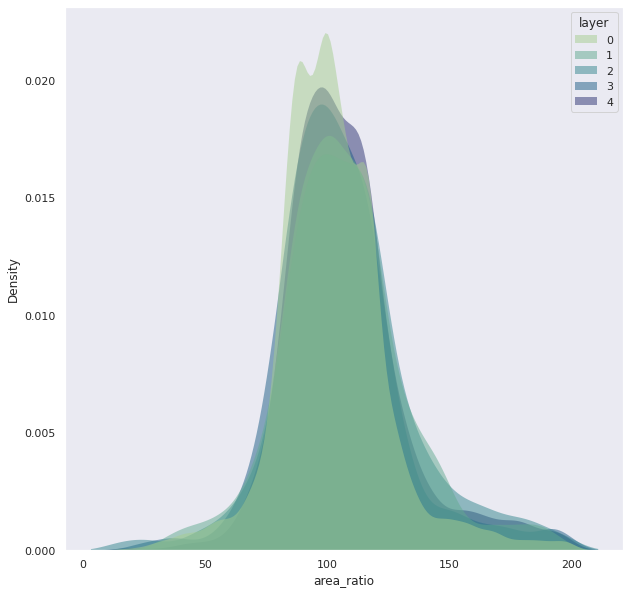

In [92]:
score_report = custom_new_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0")
normal_area = score_report[score_report['area_ratio']<200]

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(ax=ax, data=normal_area, x= 'area_ratio', hue='layer', palette="crest", common_norm=False, common_grid=True, fill=True, alpha=.5, linewidth=0)
ax.grid()

In [102]:
print(f'Percentage of critical boxes because of the low iou score: {len(ref_new_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0"))/len(ref_new_report)}')

Percentage of critical boxes because of the low iou score: 0.3204432132963989


In [103]:
print(f'Percentage of critical boxes because of the low iou score: {len(custom_new_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0"))/len(custom_new_report)}')

Percentage of critical boxes because of the low iou score: 0.22053057478935514


In [105]:
print(f'Percentage of critical boxes because of the non-corresponding labels: {len(ref_new_report.query("F_lab!=G_lab and confidence_covered==1.0"))/len(ref_new_report)}')

Percentage of critical boxes because of the non-corresponding labels: 0.1609972299168975


In [106]:
print(f'Percentage of critical boxes because of the non-corresponding labels: {len(custom_new_report.query("F_lab!=G_lab and confidence_covered==1.0"))/len(custom_new_report)}')

Percentage of critical boxes because of the non-corresponding labels: 0.08870025861349795


In [48]:
custom_new_report['f_candidate_conf']

0        70.250231
1        72.445029
2        91.685903
3        75.531143
4        78.883046
           ...    
47943    70.263648
47944    70.903325
47945    59.896320
47946    75.238734
47947    79.902363
Name: f_candidate_conf, Length: 47948, dtype: float64

In [52]:
score_report = pd.DataFrame([])
df_list = [custom_new_report, quant_new_report, ref_new_report]
# MRAD_by_layer['Custom ReLU'] = (custom_new_report.groupby('layer')['img_Top1_Crit'].mean()/200)*100
# MRAD_by_layer['Quantization distribution cut'] = (quant_new_report.groupby('layer')['img_Top1_Crit'].mean()/200)*100
# MRAD_by_layer['Swap ReLU6'] = (swap_new_report.groupby('layer')['img_Top1_Crit'].mean()/200)*100
# MRAD_by_layer['Ranger'] = (ranger_new_report.groupby('layer')['img_Top1_Crit'].mean()/200)*100
# MRAD_by_layer['Weak model'] = (ref_new_report.groupby('layer')['img_Top1_Crit'].mean()/200)*100
for idx in range(len(df_list)):
    current_df = df_list[idx]
    current_df['confidence_ratio'] = current_df['f_candidate_conf'] / current_df['G_score']
    current_df['confidence_ratio'] = current_df.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0")['confidence_ratio']
    # current_df['img_Top1_Crit'] = (current_df['MRAD']/200)*100

    if idx==0:
        current_df['Hardening strategy'] = 'Adaptive Clipper'
    elif idx ==1: 
        current_df['Hardening strategy'] = 'Saturation Quantizer'
    elif idx==2:
        current_df['Hardening strategy'] = 'Baseline'
    
    score_report=pd.concat([score_report, current_df], ignore_index=True)

In [ ]:
# score_report=pd.DataFrame([])
# ref_general_report['confidence_ratio'] = ref_general_report['f_candidate_conf'] / ref_general_report['G_score']
# score_report = ref_general_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0")['confidence_ratio']
# # ref_general_report['confidence_ratio'].describe()

In [53]:
score_report

,FaultID,imID,layer,kernel,channel,row,col,bitmask,G_lab,g_bb,...,T_count,area_ratio,confidence_covered,f_candidate_conf,iou score,conf_detail,bit_faulty_position,iou_score,confidence_ratio,Hardening strategy
0,F_1_results,1,0,58,1,2,0,33554432,1,"[373.4974670410156, 101.23625183105469, 482.89...",...,9,103.825565,1.0,70.250231,63.505918,cnf6,25.0,63.505918,0.972185,Adaptive Clipper
1,F_1_results,14,0,58,1,2,0,33554432,88,"[250.42538452148438, 152.33786010742188, 353.5...",...,3,119.342604,1.0,72.445029,83.792373,cnf6,25.0,83.792373,1.021940,Adaptive Clipper
2,F_1_results,45,0,58,1,2,0,33554432,1,"[170.27984619140625, 160.39866638183594, 349.7...",...,4,105.740354,1.0,91.685903,81.411332,cnf6,25.0,81.411332,0.993295,Adaptive Clipper
3,F_1_results,86,0,58,1,2,0,33554432,65,"[3.141845703125, 188.39329528808594, 479.01724...",...,2,83.599089,1.0,75.531143,79.012908,cnf6,25.0,79.012908,0.979153,Adaptive Clipper
4,F_1_results,92,0,58,1,2,0,33554432,17,"[75.8128433227539, 279.0757141113281, 374.9961...",...,2,87.661590,1.0,78.883046,82.207531,cnf6,25.0,82.207531,0.984433,Adaptive Clipper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76745,F_1571_results,94,4,2,62,2,2,1073741824,76,"[169.0773162841797, 281.2928771972656, 337.299...",...,8,237.381404,1.0,89.792764,11.753614,cnf6,30.0,11.753614,NaN,Baseline
76746,F_1571_results,95,4,2,62,2,2,1073741824,1,"[333.4523010253906, 91.63587951660156, 447.522...",...,20,111.729791,1.0,90.054846,76.549611,cnf6,30.0,76.549611,NaN,Baseline
76747,F_1571_results,97,4,2,62,2,2,1073741824,1,"[526.547607421875, 136.5509796142578, 592.0809...",...,15,98.323255,0.0,2.191097,20.450751,cnf6,30.0,20.450751,NaN,Baseline
76748,F_1571_results,98,4,2,62,2,2,1073741824,9,"[197.3719482421875, 177.2023468017578, 386.739...",...,10,117.959333,0.0,21.938543,70.404569,cnf6,30.0,70.404569,NaN,Baseline


Text(0.5, 1.0, 'confidence ratio')

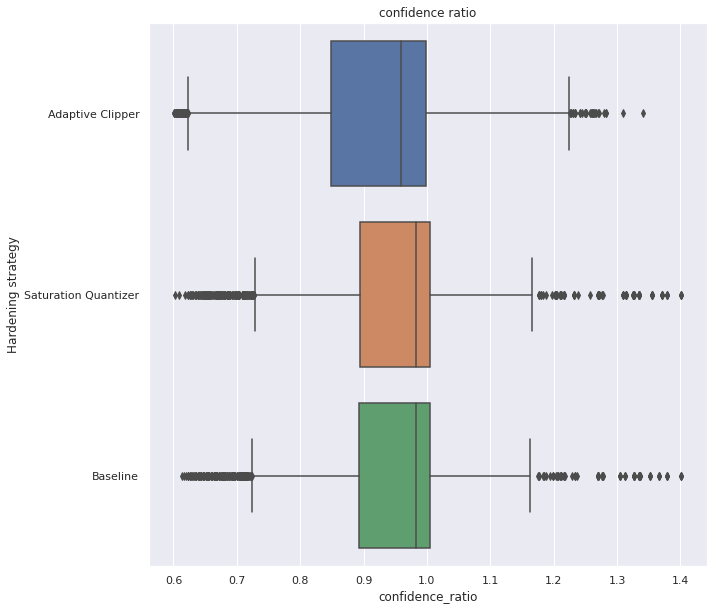

In [54]:
# score_report['confidence_ratio'] = np.log(score_report['confidence_ratio'])
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.boxplot(x='confidence_ratio', y = 'Hardening strategy', data = score_report)
ax.set_title('confidence ratio')